# Recurrent neural network for name classification
Closely following this PyTorch [tutorial]( https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html) and https://www.youtube.com/watch?v=WEV61GmmPrk.


In [1]:
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt

from utils import ALL_LETTERS, N_LETTERS
from utils import load_data, letter_to_tensor, letter_to_index, line_to_tensor, random_training_example



## Model Class

In [2]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.combined_to_hidden = nn.Linear(input_size + hidden_size, 
                                            hidden_size)
        self.combined_to_output = nn.Linear(input_size + hidden_size, 
                                            output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), dim=1)
        hidden = self.combined_to_hidden(combined)
        output = self.combined_to_output(combined)
        output = self.softmax(output) 
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)





## Load data

In [3]:
from utils import load_data
category_lines, all_categories = load_data()
n_categories = len(all_categories)
category_lines.keys()



dict_keys(['Vietnamese', 'German', 'English', 'Czech', 'Chinese', 'French', 'Russian', 'Spanish', 'Italian', 'Japanese', 'Portuguese', 'Irish', 'Korean', 'Dutch', 'Greek', 'Scottish', 'Arabic', 'Polish'])

## Build model

In [4]:
hidden_size = 128
rnn = RNN(N_LETTERS, hidden_size, n_categories)

In [5]:
# Returns the category with the highest predicted value
def category_from_output(output):
    category_idx = torch.argmax(output).item()
    return all_categories[category_idx]

In [6]:
# Run one step of the network for a single letter
input = letter_to_tensor('A')
hidden = torch.zeros(1, hidden_size)

output, next_hidden = rnn(input, hidden)
print(output.size())
print(next_hidden.size())
category_from_output(output)

torch.Size([1, 18])
torch.Size([1, 128])


'Spanish'

In [7]:
# Run one step of the network for a whole word
input = line_to_tensor('Albert')
hidden = rnn.init_hidden()

output, next_hidden = rnn(input[0], hidden)
print(output.size())
print(next_hidden.size())
category_from_output(output)

torch.Size([1, 18])
torch.Size([1, 128])


'Spanish'

### Training the network

In [8]:
criterion = nn.NLLLoss()
learning_rate = 0.005
optimizer = torch.optim.SGD(rnn.parameters(), learning_rate)

In [9]:
# One training step
def train(line_tensor, category_tensor):
    hidden = rnn.init_hidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return output, loss.item()


    

In [10]:
current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 1000
n_iters = 100000

for i in range(n_iters):
    category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)
    
    output, loss = train(line_tensor, category_tensor)
    current_loss += loss 
    
    if (i+1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0
        
    if (i+1) % print_steps == 0:
        guess = category_from_output(output)
        correct = "CORRECT" if guess == category else f"WRONG ({category})"
        print(f"{i+1} {(i+1)/n_iters*100} Loss: {loss:.4f} Current prediction: {line} / {guess} {correct}")



1000 1.0 Loss: 2.9231 Current prediction: Souza / Japanese WRONG (Portuguese)
2000 2.0 Loss: 2.8666 Current prediction: Sun / Greek WRONG (Korean)
3000 3.0 Loss: 2.7737 Current prediction: Coupe / Greek WRONG (French)
4000 4.0 Loss: 2.7836 Current prediction: Lian / Irish WRONG (Chinese)
5000 5.0 Loss: 2.7384 Current prediction: Esteves / Greek WRONG (Portuguese)
6000 6.0 Loss: 2.6388 Current prediction: Schubert / Scottish WRONG (German)
7000 7.000000000000001 Loss: 2.5188 Current prediction: Jacques / Portuguese WRONG (French)
8000 8.0 Loss: 2.3471 Current prediction: Momotani / Italian WRONG (Japanese)
9000 9.0 Loss: 2.0439 Current prediction: Castell / Spanish CORRECT
10000 10.0 Loss: 2.9193 Current prediction: Peaper / German WRONG (English)
11000 11.0 Loss: 2.3223 Current prediction: Plourde / English WRONG (French)
12000 12.0 Loss: 1.3270 Current prediction: Ahn / Korean CORRECT
13000 13.0 Loss: 1.6284 Current prediction: Nader / Arabic CORRECT
14000 14.000000000000002 Loss: 1.3

KeyboardInterrupt: 

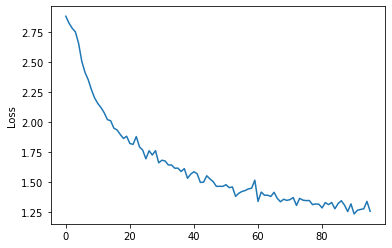

In [11]:
plt.figure()
plt.plot(all_losses)
plt.ylabel('Loss')
plt.show()

## Test the trained model

In [12]:
def predict(input_line):
    print(f"\n> {input_line}")
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)
        
        hidden = rnn.init_hidden()
    
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)
        
        prediction = category_from_output(output)
        print(prediction)

In [16]:
predict('Mao')


> Mao
Chinese
